In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
from scipy.linalg import block_diag
%matplotlib inline

In [2]:
### SET UP THE PRIOR ###

# number of nuisance parameters: must match number of photo-z bins
nz = 10

# Prior over theta
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

# Prior over eta (nuisances)
eta_lower = np.ones(nz)*-0.1
eta_upper = np.ones(nz)*0.1
eta_mean = np.zeros(nz)
eta_covariance = np.eye(nz)*0.05**2
eta_prior = priors.TruncatedGaussian(eta_mean, eta_covariance, eta_lower, eta_upper)

# Joint prior over nuisances and interesting parameters
joint_lower = np.concatenate([lower, eta_lower])
joint_upper = np.concatenate([upper, eta_upper])
joint_mean = np.concatenate([prior_mean, eta_mean])
joint_covariance = block_diag(prior_covariance, eta_covariance)
joint_prior = priors.TruncatedGaussian(joint_mean, 
                                       joint_covariance,
                                       joint_lower,
                                       joint_upper)

In [3]:
### SET UP THE SIMULATOR ###

# import tomographic n(z)
pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb'))

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShearPhotoz(pz = pz, lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    
    # Draw nuisances from prior
    eta_prior = simulator_args[0]
    eta = eta_prior.draw()
    
    return CosmicShearSimulator.simulate(np.concatenate([theta, eta]), seed)
simulator_args = [eta_prior]

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
eta_fiducial = np.zeros(len(pz))

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(np.concatenate([theta_fiducial, eta_fiducial]))
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = CosmicShearSimulator.compute_derivatives(np.concatenate([theta_fiducial, eta_fiducial]), h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(np.concatenate([theta_fiducial, eta_fiducial]), nl, Cinv, dCdt, prior_mean=joint_mean, prior_covariance=joint_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv[0:5,0:5]

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.projected_scoreMLE(d, np.arange(5,15))
compressor_args = None

In [35]:
### LOAD IN THE DATA VECTOR ###
data = compressor(simulator(theta_fiducial, np.random.randint(10000), simulator_args), compressor_args)

In [40]:
# Create the neural density estimator (MAF)
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
Delfi = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 36.5533, Val_loss: 37.5858
Epoch 00001, Train_loss: 21.4034, Val_loss: 22.0358
Epoch 00002, Train_loss: 18.7052, Val_loss: 18.1088
Epoch 00003, Train_loss: 17.4207, Val_loss: 17.2764
Epoch 00004, Train_loss: 16.8518, Val_loss: 16.7053
Epoch 00005, Train_loss: 16.3027, Val_loss: 16.2586
Epoch 00006, Train_loss: 15.8270, Val_loss: 15.7740
Epoch 00007, Train_loss: 15.2793, Val_loss: 15.3264
Epoch 00008, Train_loss: 14.8218, Val_loss: 14.8298
Epoch 00009, Train_loss: 14.4207, Val_loss: 14.4114
Epoch 00010, Train_loss: 13.8330, Val_loss: 13.8945
Epoch 00011, Train_loss: 13.2961, Val_loss: 13.2804
Epoch 00012, Train_loss: 12.8472, Val_loss: 12.9860
Epoch 00013, Train_loss: 12.2545, Val_loss: 12.2990
Epoch 00014, Train_loss: 11.6474, Val_loss: 11.6988
Epoch 00015, Train_loss: 11.1314, Val_loss: 11.1820
Epoch 00016, Train_loss: 10.7925, Val_loss: 10.8559
Epoch 00017, Train_loss: 10.4935, Va

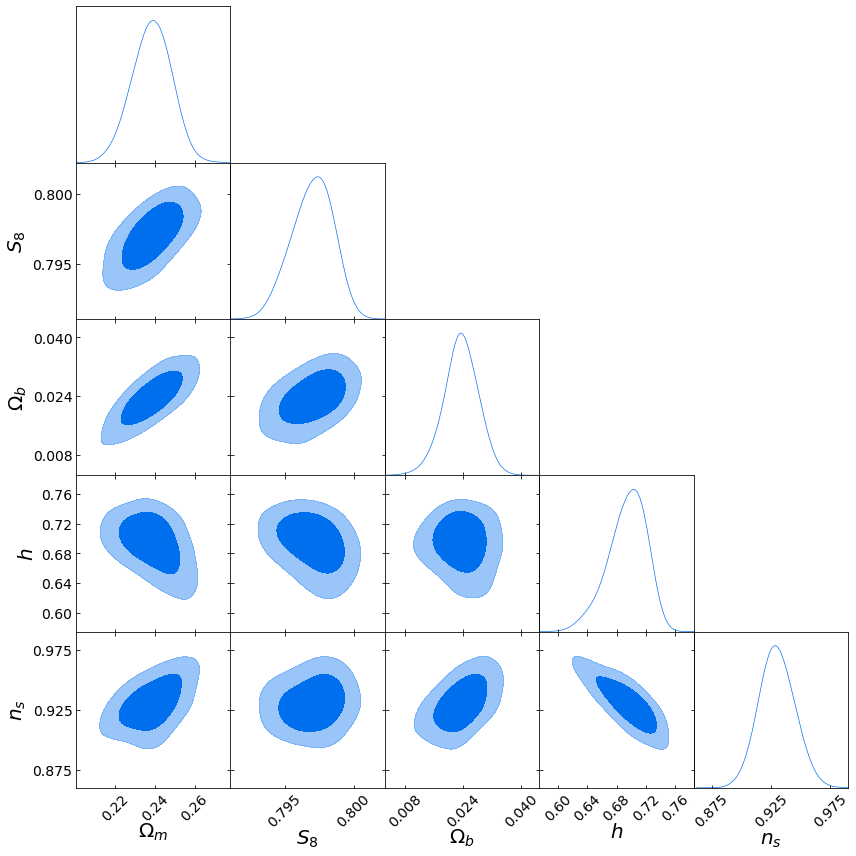

In [41]:
# Do the Fisher pre-training
Delfi.fisher_pretraining(50000, prior, epochs=100, patience=20)

Running initial 500 sims...


/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_JUSTIN/simulators/cosmic_shear/cosmic_shear.py:258: RuntimeWarning: invalid value encountered in log
  logpkz = np.log(cosmo.pk(np.exp(logk), z2a(z)))


Simulator returns exception for parameter values: [0.1975335  0.79438228 0.00912991 0.65032344 0.94135349] (rank 0)
Done.
Epoch 00000, Train_loss: 13.6081, Val_loss: 12.9142
Epoch 00001, Train_loss: 13.9185, Val_loss: 13.8373
Epoch 00002, Train_loss: 13.9288, Val_loss: 13.9443
Epoch 00003, Train_loss: 13.2137, Val_loss: 13.2544
Epoch 00004, Train_loss: 12.4625, Val_loss: 12.4511
Epoch 00005, Train_loss: 11.9785, Val_loss: 12.0042
Epoch 00006, Train_loss: 11.6487, Val_loss: 11.7032
Epoch 00007, Train_loss: 11.3811, Val_loss: 11.3815
Epoch 00008, Train_loss: 11.2293, Val_loss: 11.2119
Epoch 00009, Train_loss: 11.0724, Val_loss: 11.0594
Epoch 00010, Train_loss: 10.9534, Val_loss: 10.9713
Epoch 00011, Train_loss: 10.8542, Val_loss: 10.7914
Epoch 00012, Train_loss: 10.7872, Val_loss: 10.7911
Epoch 00013, Train_loss: 10.7024, Val_loss: 10.6510
Epoch 00014, Train_loss: 10.6019, Val_loss: 10.6297
Epoch 00015, Train_loss: 10.5361, Val_loss: 10.5697
Epoch 00016, Train_loss: 10.4877, Val_loss: 10

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_0.pdf


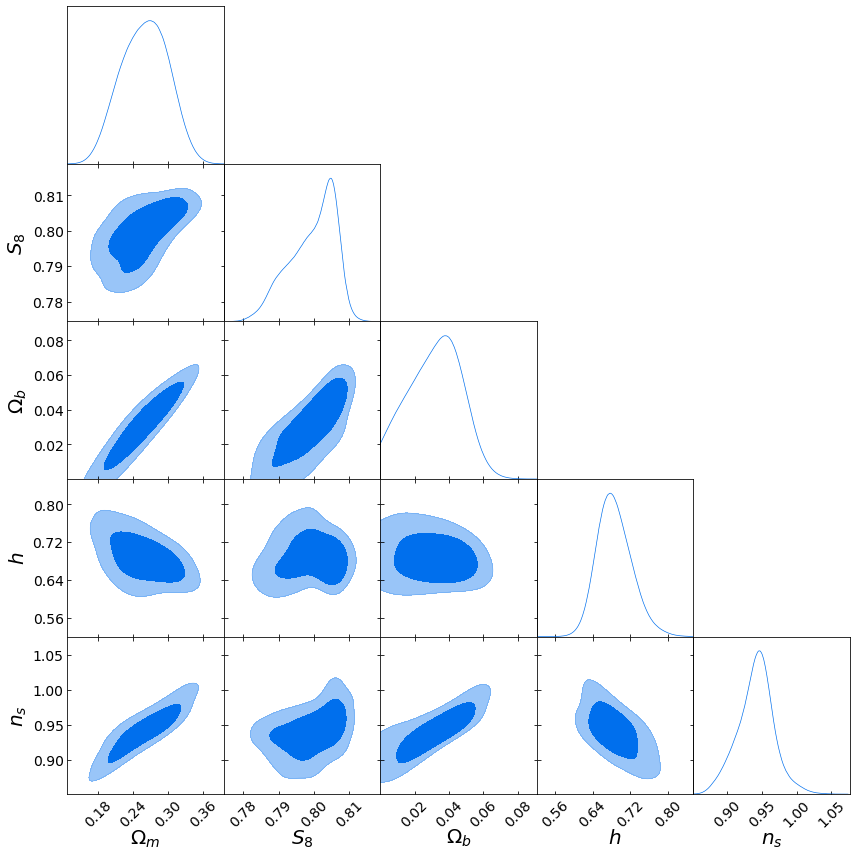

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.16601917 0.79483693 0.00597679 0.79271382 0.85495215] (rank 0)
Simulator returns exception for parameter values: [0.16601917 0.79483693 0.00597679 0.79271382 0.85495215] (rank 0)
Done.
Epoch 00000, Train_loss: 10.9695, Val_loss: 11.0151
Epoch 00001, Train_loss: 10.6785, Val_loss: 10.6972
Epoch 00002, Train_loss: 10.4822, Val_loss: 10.5676
Epoch 00003, Train_loss: 10.3776, Val_loss: 10.5016
Epoch 00004, Train_loss: 10.3243, Val_loss: 10.4292
Epoch 00005, Train_loss: 10.2556, Val_loss: 10.4555
Epoch 00006, Train_loss: 10.2543, Val_loss: 10.4506
Epoch 00007, Train_loss: 10.1901, Val_loss: 10.4441
Epoch 00008, Train_loss: 10.1667, Val_loss: 10.4551
Epoch 00009, Train_loss: 10.1552, Val_loss: 10.4966
Epoch 00010, Train_loss: 10.1137, Val_loss: 10.5350
Epoch 00011, Train_loss: 10.0804, Val_loss: 10.4634
Epoch 00012, Train_loss: 10.0954, Val_loss: 10.4697
Epoch 00013, Tr

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_1.pdf


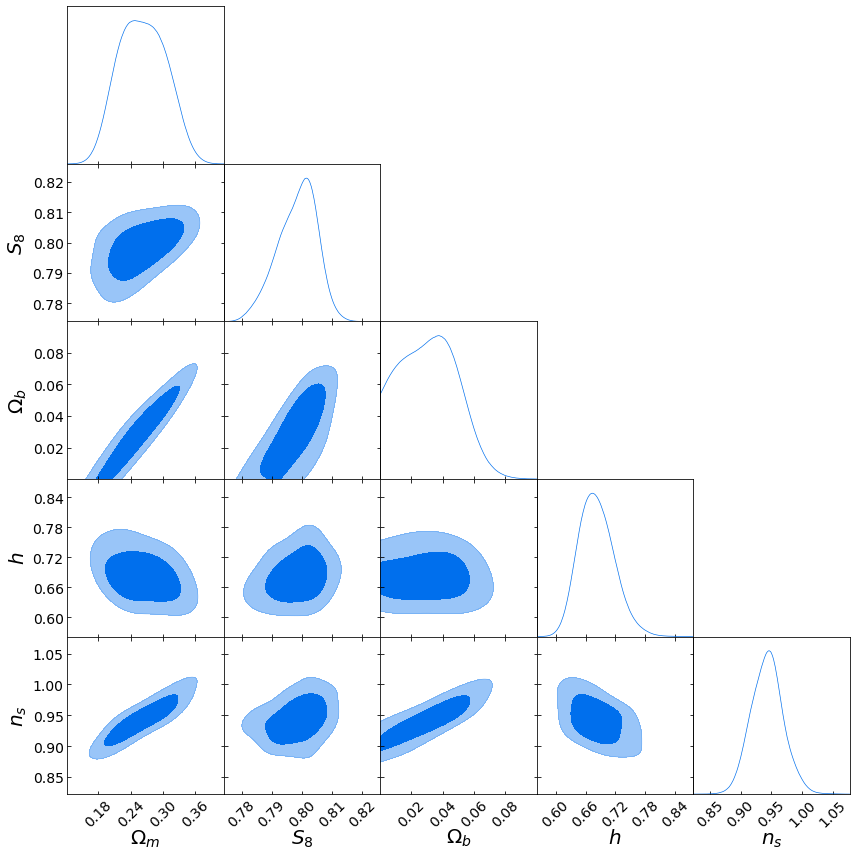

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


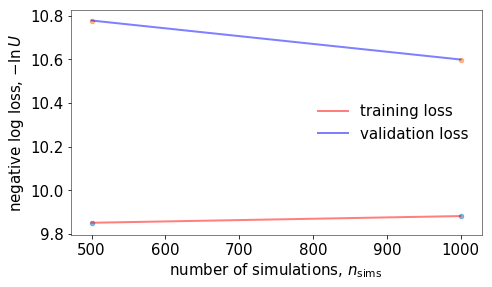

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.17869614 0.81154881 0.02533986 0.76687002 0.89014329] (rank 0)
Done.
Epoch 00000, Train_loss: 10.5902, Val_loss: 10.7057
Epoch 00001, Train_loss: 10.4904, Val_loss: 10.5585
Epoch 00002, Train_loss: 10.4315, Val_loss: 10.5586
Epoch 00003, Train_loss: 10.3780, Val_loss: 10.4681
Epoch 00004, Train_loss: 10.3388, Val_loss: 10.4391
Epoch 00005, Train_loss: 10.3024, Val_loss: 10.4250
Epoch 00006, Train_loss: 10.2740, Val_loss: 10.4031
Epoch 00007, Train_loss: 10.2440, Val_loss: 10.3938
Epoch 00008, Train_loss: 10.2256, Val_loss: 10.3969
Epoch 00009, Train_loss: 10.2298, Val_loss: 10.4043
Epoch 00010, Train_loss: 10.1933, Val_loss: 10.3414
Epoch 00011, Train_loss: 10.2095, Val_loss: 10.4180
Epoch 00012, Train_loss: 10.1453, Val_loss: 10.3030
Epoch 00013, Train_loss: 10.1293, Val_loss: 10.3591
Epoch 00014, Train_loss: 10.1488, Val_loss: 10.3419
Epoch 00015, Train_loss: 10

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_2.pdf


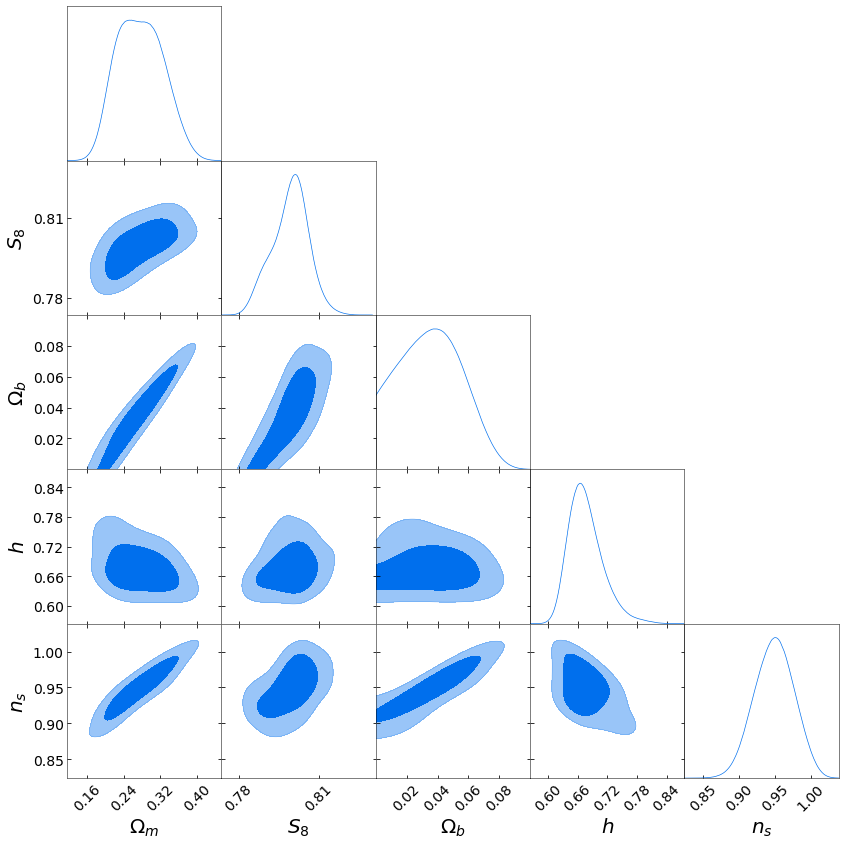

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


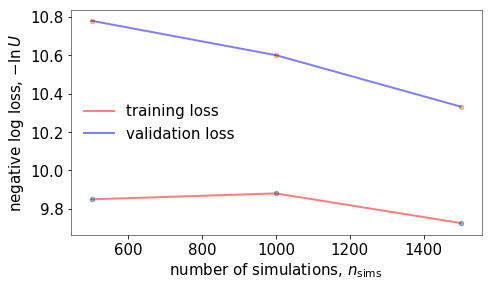

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 10.1526, Val_loss: 10.1533
Epoch 00001, Train_loss: 10.0800, Val_loss: 10.1271
Epoch 00002, Train_loss: 10.0534, Val_loss: 10.1529
Epoch 00003, Train_loss: 10.0306, Val_loss: 10.1253
Epoch 00004, Train_loss: 10.0145, Val_loss: 10.1358
Epoch 00005, Train_loss: 9.9975, Val_loss: 10.1362
Epoch 00006, Train_loss: 9.9802, Val_loss: 10.1212
Epoch 00007, Train_loss: 9.9726, Val_loss: 10.1408
Epoch 00008, Train_loss: 9.9564, Val_loss: 10.1344
Epoch 00009, Train_loss: 9.9603, Val_loss: 10.1428
Epoch 00010, Train_loss: 9.9453, Val_loss: 10.1374
Epoch 00011, Train_loss: 9.9479, Val_loss: 10.1653
Epoch 00012, Train_loss: 9.9209, Val_loss: 10.1357
Epoch 00013, Train_loss: 9.9237, Val_loss: 10.1403
Epoch 00014, Train_loss: 9.9057, Val_loss: 10.1452
Epoch 00015, Train_loss: 9.8961, Val_loss: 10.1261
Epoch 00016, Train_loss: 9.9184, Val_loss: 10.2002
Epoch 00017, Train_loss: 9.8781, Val_loss: 10.1473


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_3.pdf


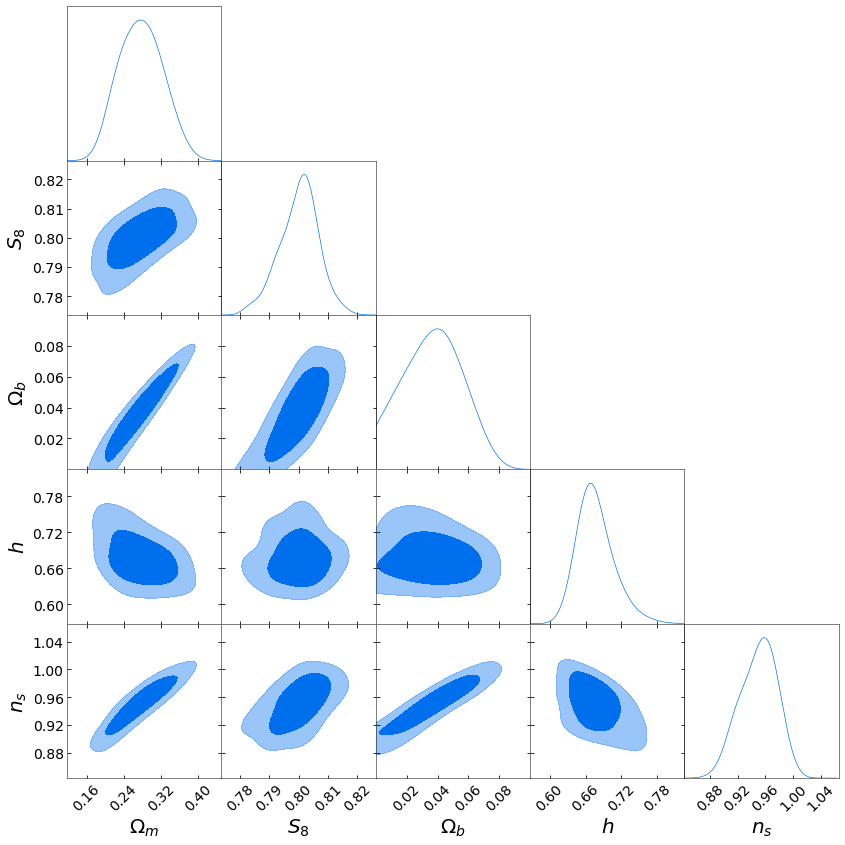

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


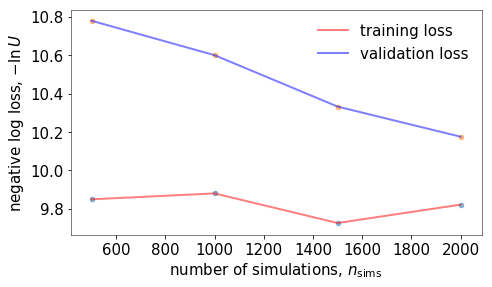

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.17059291 0.79732162 0.00582821 0.69947383 0.90487939] (rank 0)
Simulator returns exception for parameter values: [0.17059291 0.79732162 0.00582821 0.69947383 0.90487939] (rank 0)
Simulator returns exception for parameter values: [0.17604179 0.79716379 0.00716493 0.70066141 0.90550068] (rank 0)
Simulator returns exception for parameter values: [0.17604179 0.79716379 0.00716493 0.70066141 0.90550068] (rank 0)
Simulator returns exception for parameter values: [0.17604179 0.79716379 0.00716493 0.70066141 0.90550068] (rank 0)
Simulator returns exception for parameter values: [0.17604179 0.79716379 0.00716493 0.70066141 0.90550068] (rank 0)
Simulator returns exception for parameter values: [0.17604179 0.79716379 0.00716493 0.70066141 0.90550068] (rank 0)
Simulator returns exception for parameter values: [0.17604179 0.79716379 0.00716493 0.70066141 0.90550068] (rank 0)
S

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_4.pdf


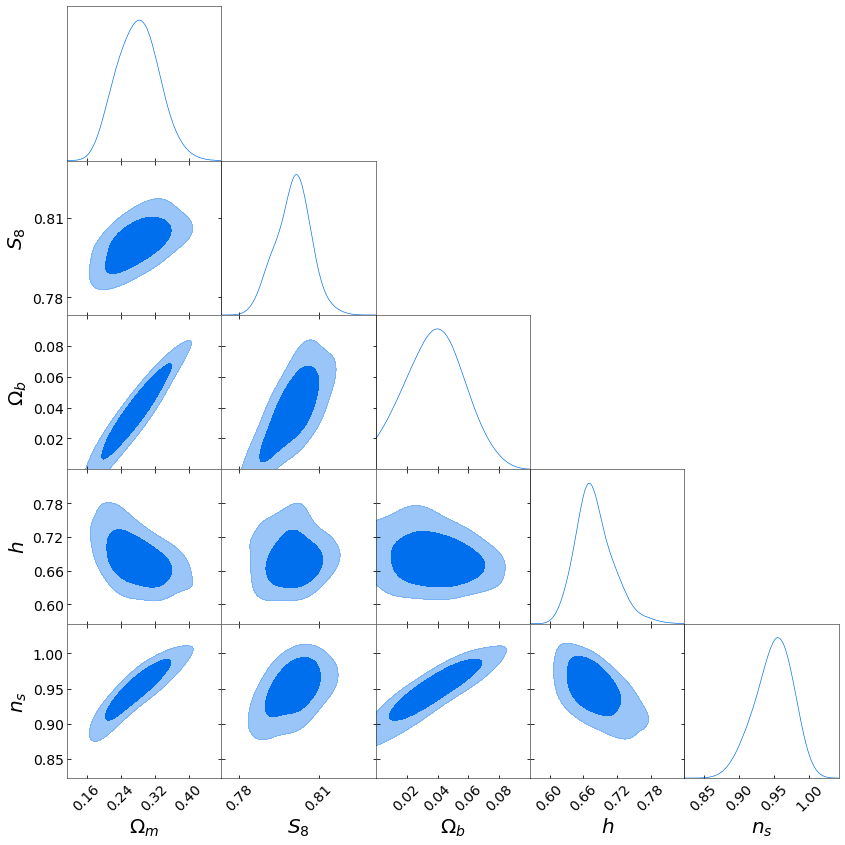

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


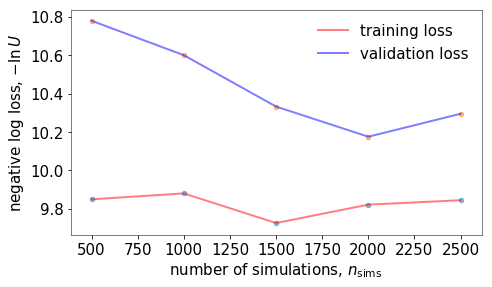

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.14377817 0.78324578 0.00110825 0.75783045 0.87298358] (rank 0)
Simulator returns exception for parameter values: [0.14377817 0.78324578 0.00110825 0.75783045 0.87298358] (rank 0)
Simulator returns exception for parameter values: [0.14377817 0.78324578 0.00110825 0.75783045 0.87298358] (rank 0)
Simulator returns exception for parameter values: [0.14377817 0.78324578 0.00110825 0.75783045 0.87298358] (rank 0)
Simulator returns exception for parameter values: [0.14377817 0.78324578 0.00110825 0.75783045 0.87298358] (rank 0)
Simulator returns exception for parameter values: [0.14377817 0.78324578 0.00110825 0.75783045 0.87298358] (rank 0)
Done.
Epoch 00000, Train_loss: 10.0142, Val_loss: 9.9214
Epoch 00001, Train_loss: 9.9796, Val_loss: 9.9279
Epoch 00002, Train_loss: 9.9754, Val_loss: 9.9323
Epoch 00003, Train_loss: 9.9777, Val_loss: 9.9413
Epoch 00004, Train_loss: 9

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_5.pdf


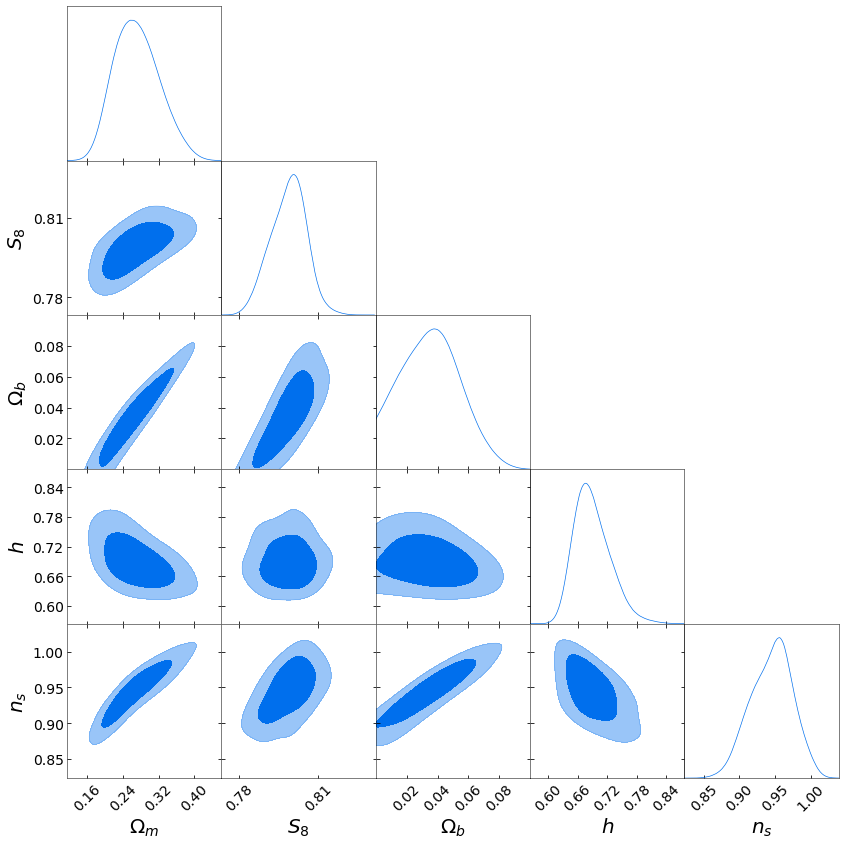

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


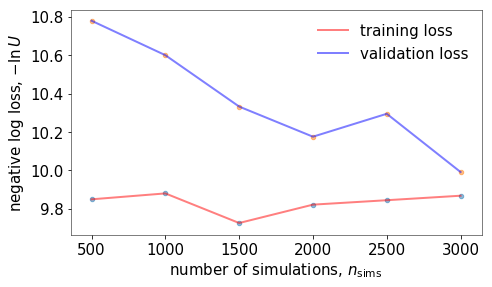

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.15104074 0.79698478 0.01212474 0.87804246 0.83327259] (rank 0)
Simulator returns exception for parameter values: [0.15104074 0.79698478 0.01212474 0.87804246 0.83327259] (rank 0)
Simulator returns exception for parameter values: [0.15104074 0.79698478 0.01212474 0.87804246 0.83327259] (rank 0)
Simulator returns exception for parameter values: [0.17031525 0.79620765 0.01503986 0.75340768 0.90461384] (rank 0)
Simulator returns exception for parameter values: [0.16670146 0.79716655 0.01192376 0.744163   0.89990457] (rank 0)
Simulator returns exception for parameter values: [0.16670146 0.79716655 0.01192376 0.744163   0.89990457] (rank 0)
Done.
Epoch 00000, Train_loss: 10.0325, Val_loss: 10.2064
Epoch 00001, Train_loss: 10.0200, Val_loss: 10.2207
Epoch 00002, Train_loss: 10.0140, Val_loss: 10.2160
Epoch 00003, Train_loss: 10.0050, Val_loss: 10.2280
Epoch 00004, Train_

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_6.pdf


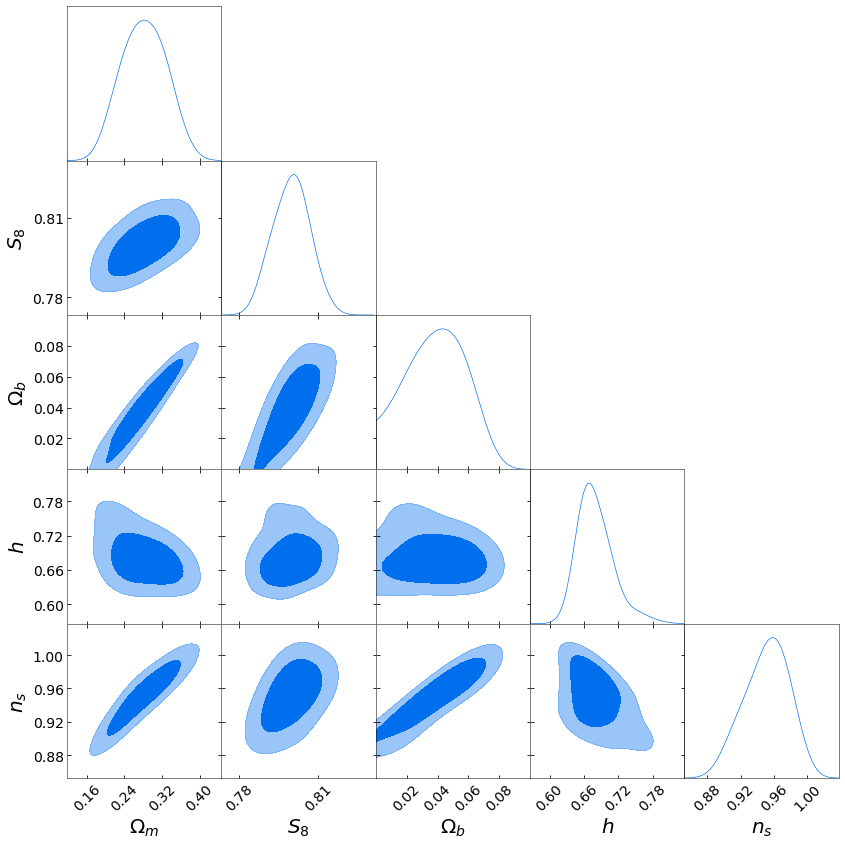

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


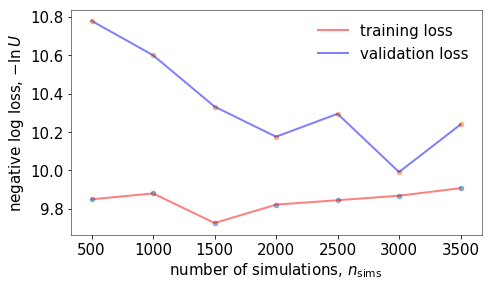

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 10.0665, Val_loss: 10.1315
Epoch 00001, Train_loss: 10.0626, Val_loss: 10.1526
Epoch 00002, Train_loss: 10.0632, Val_loss: 10.1692
Epoch 00003, Train_loss: 10.0451, Val_loss: 10.1635
Epoch 00004, Train_loss: 10.0393, Val_loss: 10.1512
Epoch 00005, Train_loss: 10.0289, Val_loss: 10.1392
Epoch 00006, Train_loss: 10.0352, Val_loss: 10.1800
Epoch 00007, Train_loss: 10.0077, Val_loss: 10.1428
Epoch 00008, Train_loss: 10.0082, Val_loss: 10.1603
Epoch 00009, Train_loss: 10.0032, Val_loss: 10.1488
Epoch 00010, Train_loss: 9.9960, Val_loss: 10.1505
Epoch 00011, Train_loss: 9.9951, Val_loss: 10.1516
Epoch 00012, Train_loss: 9.9836, Val_loss: 10.1588
Epoch 00013, Train_loss: 9.9941, Val_loss: 10.1503
Epoch 00014, Train_loss: 9.9800, Val_loss: 10.1476
Epoch 00015, Train_loss: 9.9681, Val_loss: 10.1488
Epoch 00016, Train_loss: 9.9654, Val_loss: 10.1674
Epoch 00017, Train_loss: 9.9593, Val_loss: 10.

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_7.pdf


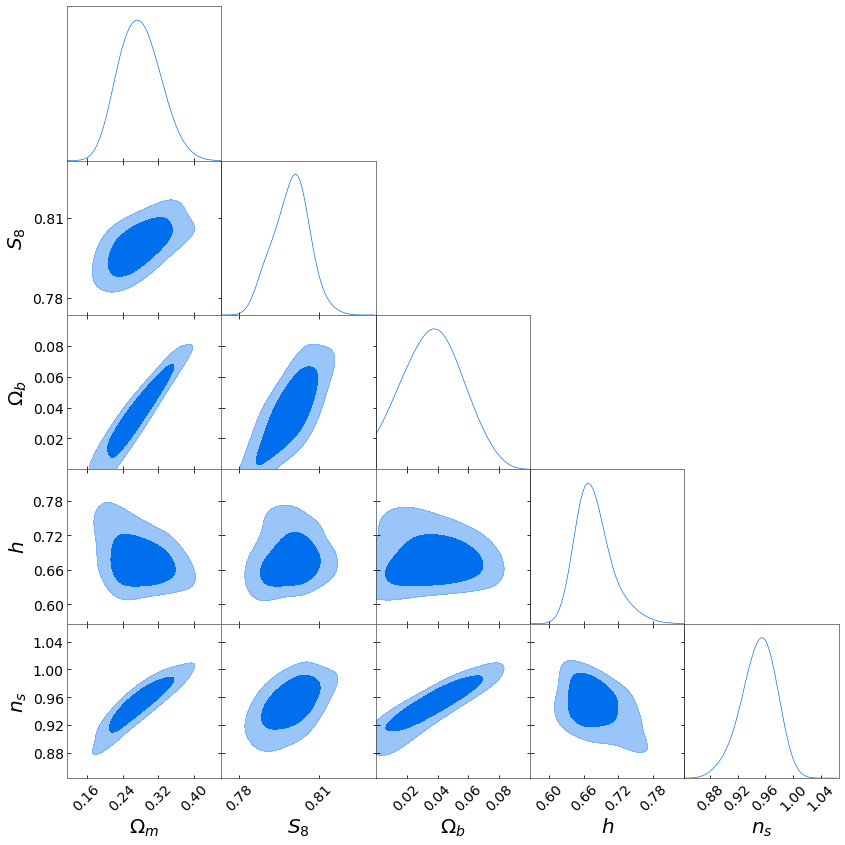

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


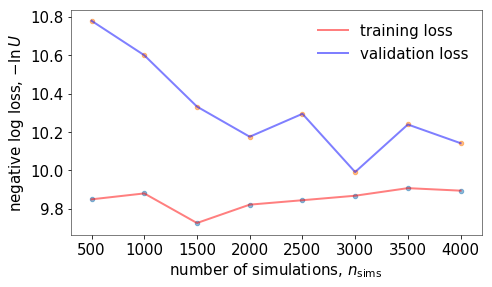

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.15253728 0.78707255 0.00459322 0.82580384 0.87454447] (rank 0)
Done.
Epoch 00000, Train_loss: 10.0104, Val_loss: 10.0117
Epoch 00001, Train_loss: 10.0069, Val_loss: 10.0214
Epoch 00002, Train_loss: 9.9962, Val_loss: 10.0260
Epoch 00003, Train_loss: 10.0042, Val_loss: 10.0468
Epoch 00004, Train_loss: 10.0019, Val_loss: 10.0593
Epoch 00005, Train_loss: 10.0002, Val_loss: 10.0468
Epoch 00006, Train_loss: 9.9950, Val_loss: 10.0653
Epoch 00007, Train_loss: 10.0018, Val_loss: 10.0356
Epoch 00008, Train_loss: 9.9792, Val_loss: 10.0500
Epoch 00009, Train_loss: 9.9683, Val_loss: 10.0217
Epoch 00010, Train_loss: 9.9657, Val_loss: 10.0524
Epoch 00011, Train_loss: 9.9583, Val_loss: 10.0287
Epoch 00012, Train_loss: 9.9510, Val_loss: 10.0381
Epoch 00013, Train_loss: 9.9467, Val_loss: 10.0264
Epoch 00014, Train_loss: 9.9453, Val_loss: 10.0429
Epoch 00015, Train_loss: 9.9471, Val

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_8.pdf


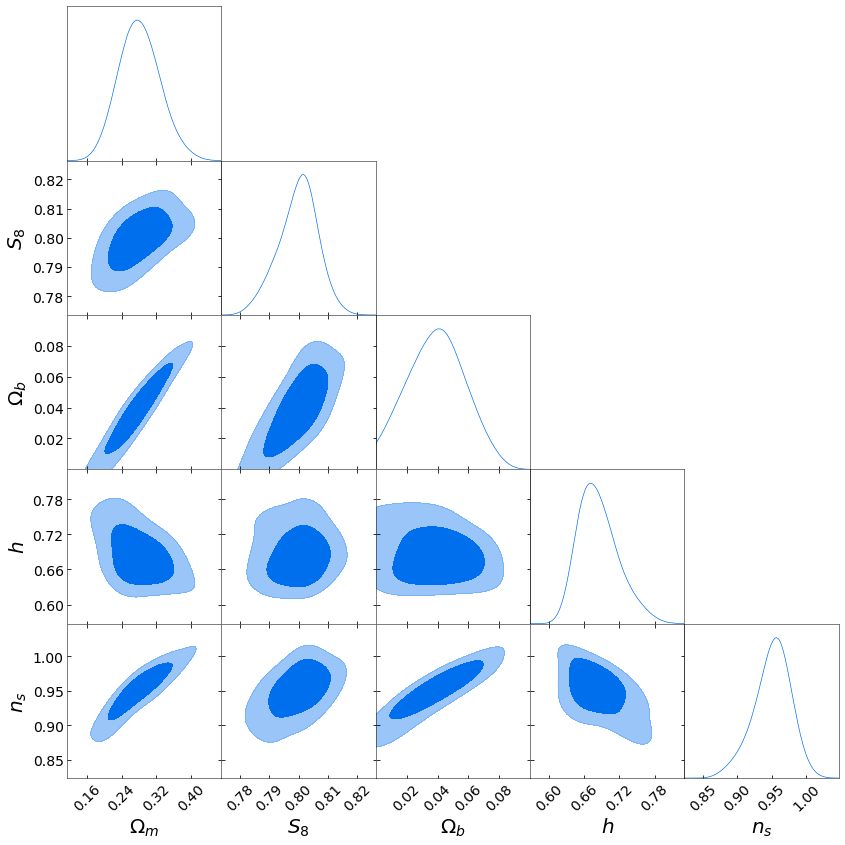

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


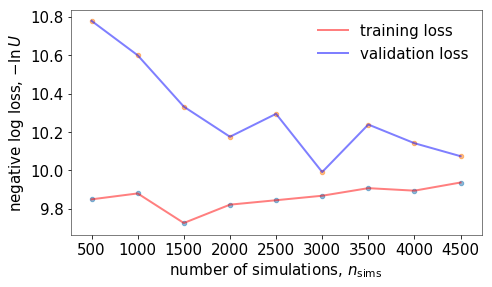

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 10.0341, Val_loss: 9.9229
Epoch 00001, Train_loss: 10.0330, Val_loss: 9.9274
Epoch 00002, Train_loss: 10.0276, Val_loss: 9.9348
Epoch 00003, Train_loss: 10.0182, Val_loss: 9.9317
Epoch 00004, Train_loss: 10.0221, Val_loss: 9.9436
Epoch 00005, Train_loss: 10.0132, Val_loss: 9.9309
Epoch 00006, Train_loss: 10.0023, Val_loss: 9.9268
Epoch 00007, Train_loss: 9.9983, Val_loss: 9.9407
Epoch 00008, Train_loss: 9.9989, Val_loss: 9.9390
Epoch 00009, Train_loss: 9.9913, Val_loss: 9.9427
Epoch 00010, Train_loss: 9.9838, Val_loss: 9.9201
Epoch 00011, Train_loss: 9.9826, Val_loss: 9.9380
Epoch 00012, Train_loss: 9.9798, Val_loss: 9.9158
Epoch 00013, Train_loss: 9.9718, Val_loss: 9.9365
Epoch 00014, Train_loss: 9.9652, Val_loss: 9.9187
Epoch 00015, Train_loss: 9.9711, Val_loss: 9.9220
Epoch 00016, Train_loss: 9.9625, Val_loss: 9.9335
Epoch 00017, Train_loss: 9.9576, Val_loss: 9.9279
Epoch 00018, Tra

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_9.pdf


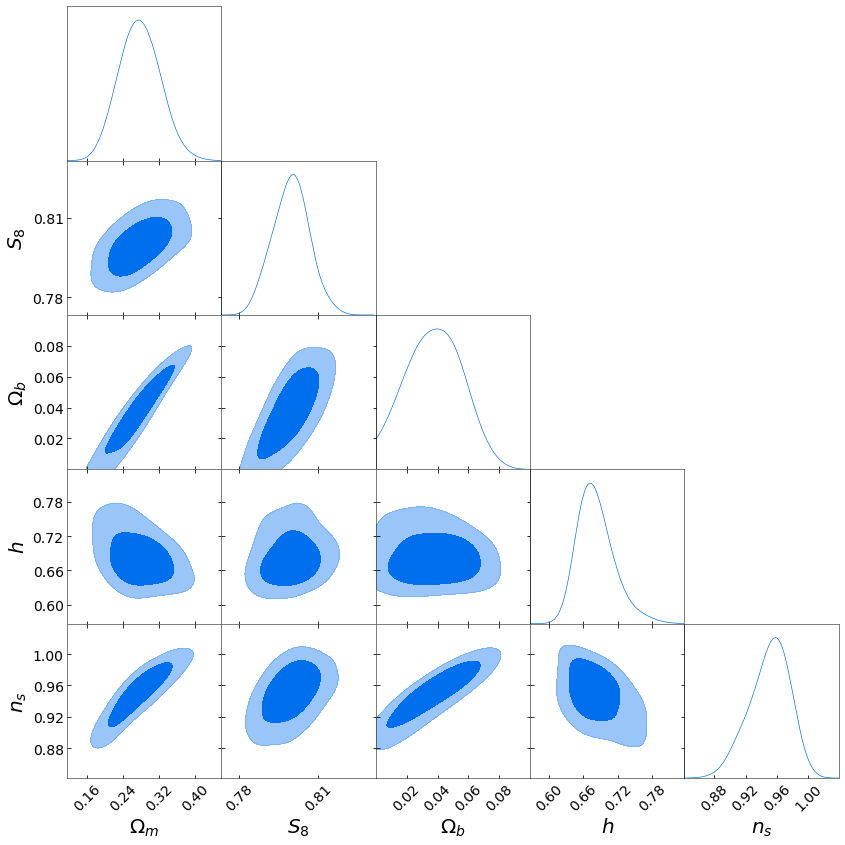

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


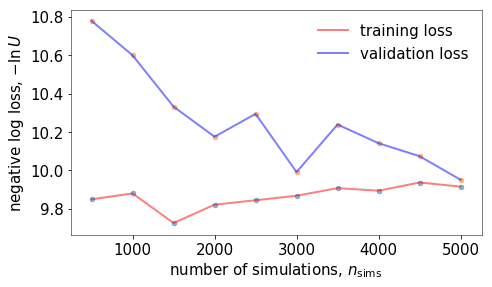

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.9759, Val_loss: 10.0544
Epoch 00001, Train_loss: 9.9585, Val_loss: 10.0290
Epoch 00002, Train_loss: 9.9444, Val_loss: 10.0383
Epoch 00003, Train_loss: 9.9429, Val_loss: 10.0327
Epoch 00004, Train_loss: 9.9266, Val_loss: 10.0307
Epoch 00005, Train_loss: 9.9254, Val_loss: 10.0244
Epoch 00006, Train_loss: 9.9173, Val_loss: 10.0276
Epoch 00007, Train_loss: 9.9219, Val_loss: 10.0454
Epoch 00008, Train_loss: 9.9206, Val_loss: 10.0341
Epoch 00009, Train_loss: 9.9113, Val_loss: 10.0368
Epoch 00010, Train_loss: 9.9179, Val_loss: 10.0477
Epoch 00011, Train_loss: 9.9056, Val_loss: 10.0367
Epoch 00012, Train_loss: 9.9091, Val_loss: 10.0459
Epoch 00013, Train_loss: 9.9039, Val_loss: 10.0487
Epoch 00014, Train_loss: 9.9024, Val_loss: 10.0458
Epoch 00015, Train_loss: 9.9185, Val_loss: 10.0648
Epoch 00016, Train_loss: 9.9101, Val_loss: 10.0594
Epoch 00017, Train_loss: 9.8877, Val_loss: 10.0540
Epoc

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_10.pdf


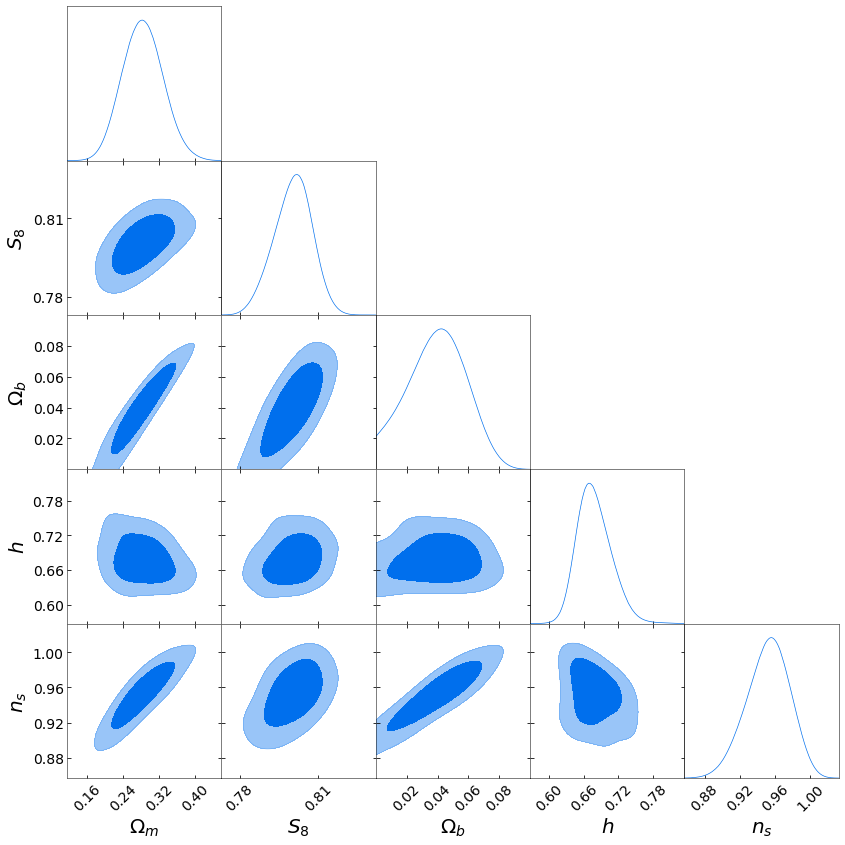

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


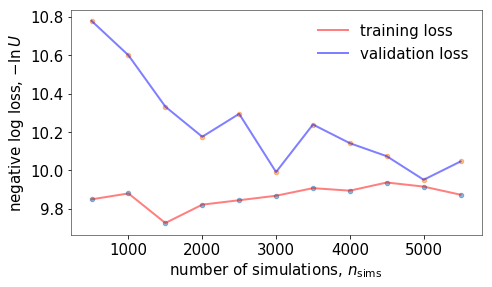

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.14798334 0.79279556 0.00304089 0.792196   0.85941179] (rank 0)
Simulator returns exception for parameter values: [0.1683271  0.79701098 0.01084062 0.77882564 0.87517471] (rank 0)
Simulator returns exception for parameter values: [0.14169078 0.79543284 0.00277052 0.79960293 0.85629538] (rank 0)


In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
Delfi.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


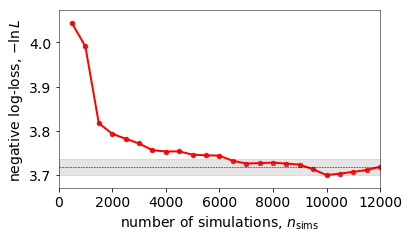

In [13]:
plt.close()
columnwidth = 15 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})

# Trace plot of the loss as a function of the number of simulations
plt.scatter(n_sims, loss_trace, s = 20)
plt.plot(n_sims, loss_trace, color = 'red', lw = 2)
plt.fill_between(mdn.n_sim_trace, loss_trace[-1]*0.995*np.ones(len(mdn.n_sim_trace)), loss_trace[-1]*1.005*np.ones(len(mdn.n_sim_trace)), color = 'grey', alpha = 0.2 )
plt.xlim(0, mdn.n_sim_trace[-1])
plt.axhline(loss_trace[-1], color = 'black', ls = '--')
plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log-loss, $-\mathrm{ln}\,L$')
plt.tight_layout()
#plt.show()
#plt.savefig('../paper_II/plots/convergence_marginal.pdf')

In [18]:
# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])

In [19]:
samples = [mdn.posterior_samples, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = mdn.names, labels = mdn.labels, ranges = mdn.ranges) for s in samples]

In [14]:
# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1], contour_ls = ['-','-.'], contour_colors=['#E41A1C','#377EB8'])

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.sho
#plt.savefig('../paper_II/plots/contours.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


NameError: name 'mc_samples' is not defined

In [16]:
ind = np.arange(0, 15)
nind = np.arange(5, 15)
pind = np.delete(ind, nind)

In [11]:
ind = np.arange(0, 5)

In [18]:
Q = np.delete(np.delete(Compressor.F, nind, axis=0), ind, axis = 1)
Q.shape

(5, 0)